# Use skorch to do random Hyperparameter search for 5G RNA-seq data (single- and multi-task)

## Forked from "5g_single_task_hyperparameter_search_skorch_single_task, which also included regular pytorch functions. removed here.
Given data that has been transformed into log-ratio TPMs, search the hyperparameter spaces of various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model

## *** Log(TPM) 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


## Load 5G logTPM data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY_log = pd.read_csv(log_data_filename,sep='\t')

display(XY_log.head())

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


In [5]:
loc2seq = dict([(x,z) for (x,z) in XY_log[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


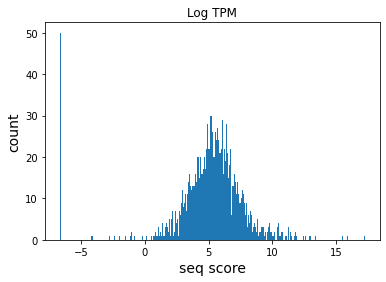

In [6]:
# Log TPM - highCu column
plt.hist(XY_log['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

In [7]:
for df in [XY_log]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])


In [8]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

## Load 5G seqs into data loaders

In [9]:
# LOG
log_full_train_df,log_test_df = tu.quick_split(XY_log)
log_train_df, log_val_df = tu.quick_split(log_full_train_df)

print(log_full_train_df.shape)
print(log_test_df.shape)
print(log_train_df.shape)
print(log_val_df.shape)

assert(log_train_df.shape[0] + log_val_df.shape[0] == log_full_train_df.shape[0])

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


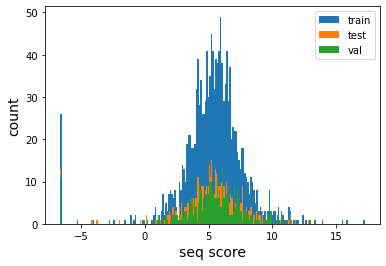

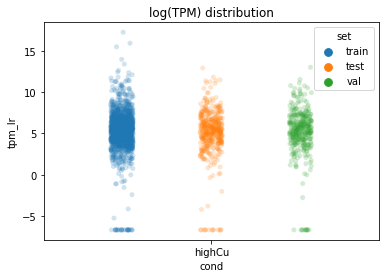

In [10]:
# plot_train_test_hist(log_full_train_df, log_test_df,score_col='highCu',bins=200)
# plot_train_test_hist(log_train_df, log_val_df,score_col='highCu',bins=200)

# split the genes, show dist of logTPM of HighCu column
plot_train_test_hist(log_train_df, log_test_df, val_df=log_val_df,score_col='highCu',bins=200)
view_train_test_dist(log_train_df, log_test_df,["highCu"],"log(TPM)",val_df=log_val_df)

## define basic single task models

In [11]:
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
            #nn.ReLU(inplace=True),
            nn.Linear(num_fc_nodes2, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

## some helper functions

In [12]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    


def quick_loss_plot_simple(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label) in enumerate(data_label_list):
        # plot only 1 in every sparse_n points
        if sparse_n:
            train_data = [x for i,x in enumerate(train_data) if (i%sparse_n==0)]
            test_data = [x for i,x in enumerate(test_data) if (i%sparse_n==0)]
            
        plt.plot(train_data,'--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,'o-',color=f"C{i}", label=f"{label} Test",linewidth=3.0)
        

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

## try fitting with skorch instead

In [13]:
def make_skorch_dfs(df,seq_col='seq',target_col='score'):
    '''
    Make basic X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    # had to unsqueeze here or else errors later
    
    return ohe_seqs.float(), labels.float()

In [14]:
X, y = make_skorch_dfs(log_full_train_df, seq_col='upstream_region',target_col='highCu')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [45]:
from skorch.callbacks import EarlyStopping,Checkpoint,LoadInitState,PrintLog,ProgressBar

In [16]:
# Make a skorch regressor object
net_regr = NeuralNetRegressor(
    DNA_CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    max_epochs=100,
    lr=0.001, # this is passed to the skorch fit, i think
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[EarlyStopping(patience=25),Checkpoint(dirname='testcheck')]
)

In [17]:
# Just call fit!
net_regr.fit(X, y)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       19.7361        7.9725     +  1.3201
      2        7.3420        8.5960        0.0452
      3        7.3264        8.4386        0.0454
      4        7.2475        8.2469        0.0446
      5        7.1644        8.0332        0.0446
      6        7.0774        7.8120     +  0.0449
      7        6.9874        7.5982     +  0.0451
      8        6.8956        7.4046     +  0.0454
      9        6.8035        7.2399     +  0.0454
     10        6.7119        7.1069     +  0.0453
     11        6.6214        7.0032     +  0.0454
     12        6.5319        6.9233     +  0.0449
     13        6.4429        6.8605     +  0.0463
     14        6.3538        6.8089     +  0.0453
     15        6.2642        6.7640     +  0.0454
     16        6.1734        6.7228     +  0.0454
     17        6.0813        6.6837     +  0.0452
     18        5.9877        6.6456     +  0.0450


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

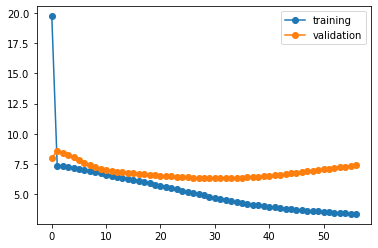

In [18]:
# plot net_regr's loss trace
train_loss = net_regr.history[:, 'train_loss']
valid_loss = net_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

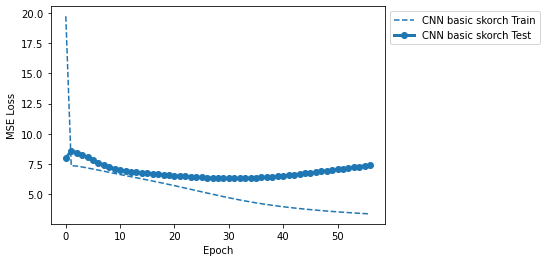

In [19]:
skorch_label = [((net_regr.history[:, 'train_loss'], net_regr.history[:, 'valid_loss']), 'CNN basic skorch')]
quick_loss_plot_simple(skorch_label)

In [20]:
#y_pred = net_regr.predict(X[:5])
y_pred = net_regr.predict(X)
y_pred = torch.tensor(y_pred).to(DEVICE)

net_regr.get_loss(y_pred, y)


tensor(4.0936, device='cuda:0')

In [21]:
def parity_plot(model_title,ytrue,ypred, pearson,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.title(f"{model_title} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()

In [22]:
# y pred and pearson on training data
ypred_train_basic = net_regr.predict(X)
p_train_basic = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_basic.flatten())


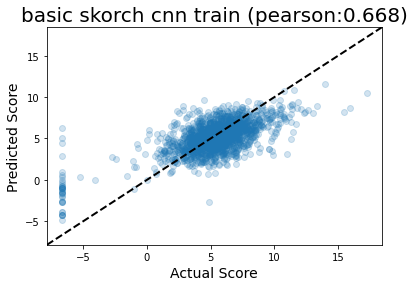

In [23]:
parity_plot("basic skorch cnn train", y, ypred_train_basic,p_train_basic[0],rigid=True)


In [24]:
Xval, yval = make_skorch_dfs(log_val_df, seq_col='upstream_region',target_col='highCu')
Xtest, ytest = make_skorch_dfs(log_test_df, seq_col='upstream_region',target_col='highCu')

In [25]:
# y pred and pearson on val data
ypred_val_basic = net_regr.predict(Xval)
p_val_basic = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_basic.flatten())

# y pred and pearson on test data
ypred_test_basic = net_regr.predict(Xtest)
p_test_basic = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_basic.flatten())

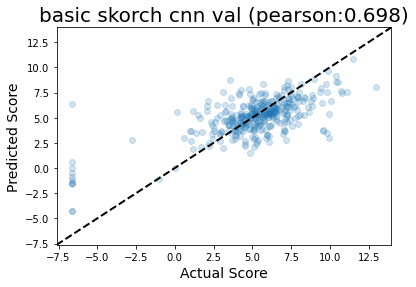

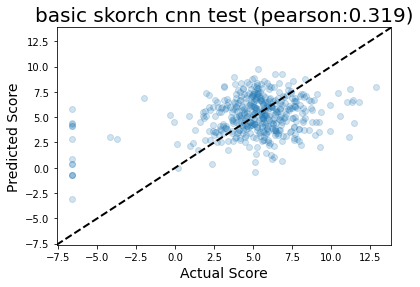

In [26]:
parity_plot("basic skorch cnn val", yval, ypred_val_basic,p_val_basic[0],rigid=True)
parity_plot("basic skorch cnn test", ytest, ypred_test_basic,p_test_basic[0],rigid=True)


## now try random search with some params

In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform,uniform
from random import randint


In [51]:
from skorch.callbacks import Callback
SEARCH_ITER = 0
class MyProgress(Callback):

    def on_train_end(self, net, **kwargs):
        print(f"SEARCH ITER {SEARCH_ITER}")
        SEARCH_ITER += 1
        

In [140]:
net_search = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[
        EarlyStopping(patience=25),#,sink=print),
        #Checkpoint(dirname='testcheck_search',f_pickle='model.pkl'),
    ]

)

In [141]:
params = {
    'lr': [0.001, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

In [142]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=50, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [143]:
search.fit(X,y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.1s


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.5523       31.5356  0.0540
      2       29.6546       26.9264  0.0521
      3       25.1607       22.6281  0.0517


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


      4       21.0107       18.7241  0.0530
      5       17.3040       15.3292  0.0524
      6       14.1518       12.5441  0.0524
      7       11.6381       10.4237  0.0525
      8        9.7900        8.9543  0.0526
      9        8.5627        8.0493  0.0529
     10        7.8445        7.5686  0.0530
     11        7.4851        7.3575  0.0533
     12        7.3372        7.2864  0.0534
     13        7.2896        7.2711  0.0529
     14        7.2769        7.2700  0.0518
     15        7.2704        7.2685  0.0522
     16        7.2615        7.2638  0.0524
     17        7.2498        7.2569  0.0525
     18        7.2362        7.2490  0.0521
     19        7.2220        7.2409  0.0528
     20        7.2075        7.2327  0.0528
     21        7.1930        7.2246  0.0525
     22        7.1785        7.2165  0.0520
     23        7.1639        7.2084  0.0522
     24        7.1492        7.2003  0.0527
     25        7.1345        7.1922  0.0525
     26        7.1196        7.1

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN'>,
  module__seq_len=300,
),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'lr': [0.001, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class 'torch.op

In [144]:
print(search.best_params_)
#print(search.best_estimator_)

{'optimizer': <class 'torch.optim.adam.Adam'>, 'module__num_filters': 128, 'module__num_fc_nodes1': 25, 'module__kernel_size': 32, 'lr': 1e-05}


In [67]:
import pickle


In [68]:
thing = pickle.load(open("testcheck_search/model.pkl",'rb'))
print(thing.optimizer)
print(thing._kwargs)


<class 'torch.optim.adam.Adam'>
{'module__seq_len': 300, 'module__num_filters': 16, 'module__num_fc_nodes1': 10, 'module__kernel_size': 32}


In [145]:
search_label2 = [((search.best_estimator_.history[:, 'train_loss'], search.best_estimator_.history[:, 'valid_loss']), 'CNN search2')]

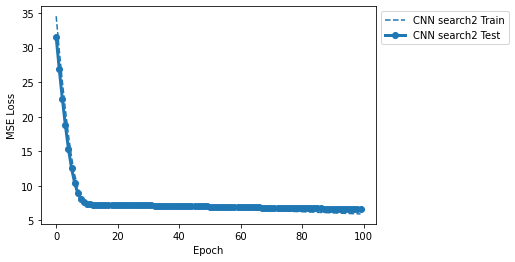

In [146]:
quick_loss_plot_simple(search_label2)

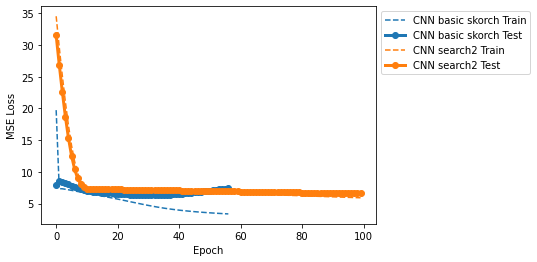

In [147]:
quick_loss_plot_simple(skorch_label+search_label2)

In [148]:
# search history all losses?
search.best_estimator_.callbacks

## Compare some scores of the model combos tested

In [149]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,6.140260,0.434702,0.015225,0.000723,<class 'torch.optim.adam.Adam'>,16,10,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-9.923470,-8.511230,-11.553613,-9.996104,1.243109,34,Adam
1,5.885383,2.944156,0.016425,0.000848,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.183587,-7.428811,-8.029267,-7.213888,0.768669,4,Adam
2,2.392634,0.302304,0.016133,0.001252,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-8.359058,-8.834317,-9.876494,-9.023290,0.633738,28,Adam
3,2.645350,0.719284,0.014296,0.000566,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-7.572649,-7.672989,-9.492111,-8.245916,0.882144,23,Adam
4,3.647100,1.627818,0.014883,0.000830,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.293587,-7.448137,-8.246672,-7.329465,0.801747,12,SGD
5,1.629643,0.116016,0.016330,0.000704,<class 'torch.optim.adam.Adam'>,64,100,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-11.149951,-11.809718,-12.695509,-11.885059,0.633216,38,Adam
6,4.122358,1.664180,0.016165,0.000641,<class 'torch.optim.rmsprop.RMSprop'>,64,100,16,0.00001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-6.381889,-7.382994,-8.187407,-7.317430,0.738556,11,RMSprop
7,3.603084,0.912941,0.015515,0.002250,<class 'torch.optim.adagrad.Adagrad'>,32,25,32,0.001,{'optimizer': <class 'torch.optim.adagrad.Adag...,-6.416245,-7.400497,-8.547892,-7.454878,0.871090,18,Adagrad
8,2.687081,1.005481,0.018503,0.000648,<class 'torch.optim.sgd.SGD'>,128,25,4,0.001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-8.258592,-8.813581,-11.579926,-9.550700,1.452658,32,SGD
9,3.097355,0.057952,0.021468,0.002822,<class 'torch.optim.adamw.AdamW'>,128,100,4,0.001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-12.300660,-13.975367,-15.353263,-13.876430,1.248182,43,AdamW


In [150]:
sm_res_df = res_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [151]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [153]:
alt.Chart(sm_res_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

## Check prediction distributions

In [52]:
Xval, yval = make_skorch_dfs(log_val_df, seq_col='upstream_region',target_col='highCu')
Xtest, ytest = make_skorch_dfs(log_test_df, seq_col='upstream_region',target_col='highCu')



In [154]:
# y pred and pearson on training data
ypred_train_search = search.best_estimator_.predict(X)
p_train_search = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_search.flatten())

# y pred and pearson on val data
ypred_val_search = search.best_estimator_.predict(Xval)
p_val_search = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_search.flatten())

# y pred and pearson on test data
ypred_test_search = search.best_estimator_.predict(Xtest)
p_test_search = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_search.flatten())



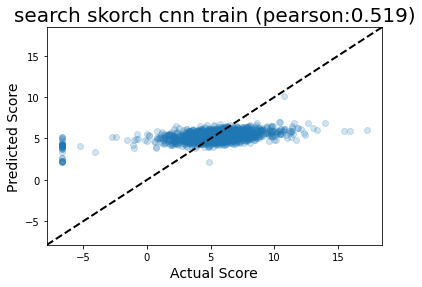

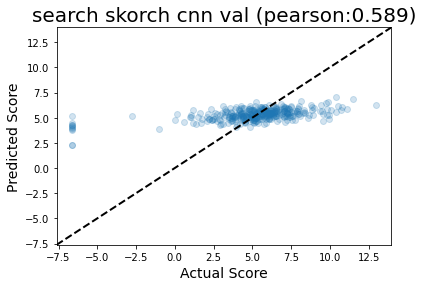

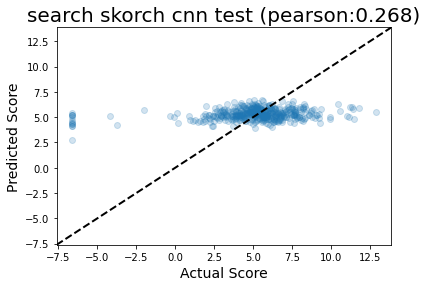

In [155]:
parity_plot("search skorch cnn train", y, ypred_train_search,p_train_search[0],rigid=True)

parity_plot("search skorch cnn val", yval, ypred_val_search,p_val_search[0],rigid=True)

parity_plot("search skorch cnn test", ytest, ypred_test_search,p_test_search[0],rigid=True)

In [156]:
def ytrue_pred_hist(y,ypred,title):
    plt.hist(ypred,alpha=0.2, label="Y Pred")
    plt.hist(np.array(y),alpha=0.2, label="Y True")
    plt.legend()
    plt.title(title)
    plt.show()
    

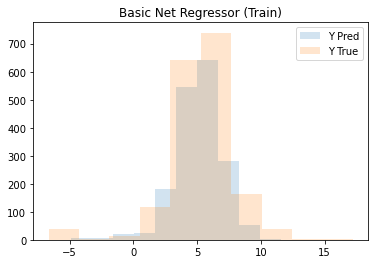

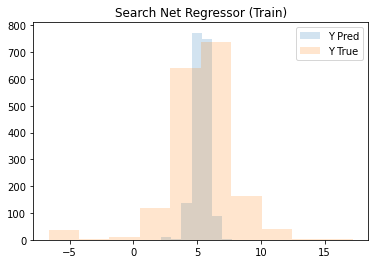

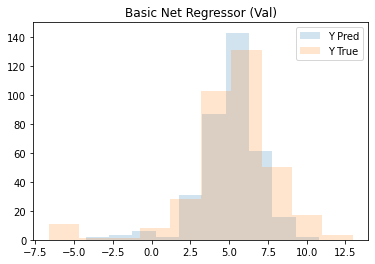

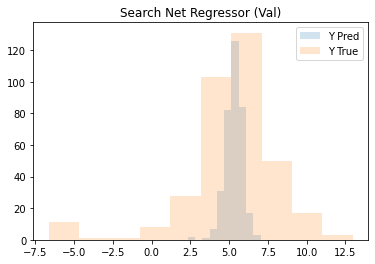

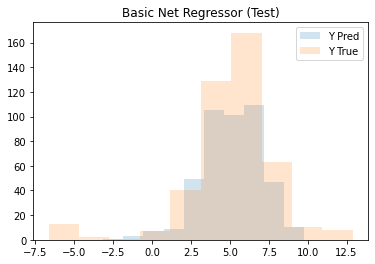

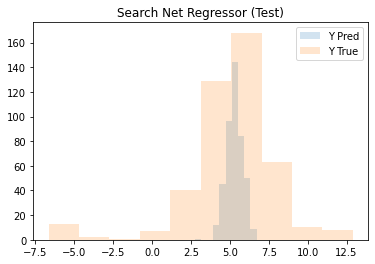

In [157]:
ytrue_pred_hist(y,ypred_train_basic,"Basic Net Regressor (Train)")
ytrue_pred_hist(y,ypred_train_search,"Search Net Regressor (Train)")

ytrue_pred_hist(yval,ypred_val_basic,"Basic Net Regressor (Val)")
ytrue_pred_hist(yval,ypred_val_search,"Search Net Regressor (Val)")

ytrue_pred_hist(ytest,ypred_test_basic,"Basic Net Regressor (Test)")
ytrue_pred_hist(ytest,ypred_test_search,"Search Net Regressor (Test)")

# Run Skorch with MT model

In [158]:
condition_file = 'data/conditions_to_include.txt'
with open(condition_file,'r') as f:
    conditions = list(x.strip() for x in f.readlines())
    
cond_dict = dict(enumerate(conditions))
cond_dict

{0: 'uMax',
 1: 'lowO2_fast_growth',
 2: 'lowCH4',
 3: 'MeOH',
 4: 'NoCu',
 5: 'medCu',
 6: 'highCu',
 7: 'lowCu',
 8: 'highO2_slow_growth',
 9: 'NO3_lowO2_slow_growth',
 10: 'WithLanthanum',
 11: 'NoLanthanum'}

In [60]:
# class DNA_CNN_Multi(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  num_filters=31,
#                  kernel_size=5,
#                  num_fc_nodes1=100,
#                  num_fc_nodes2=10
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
#         self.conv_net = nn.Sequential(
#             nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
#             # ^^ changed from 4 to 1 channel??
#             #nn.ReLU(inplace=True),
#             nn.Flatten(),
#             nn.Linear(self.lin_nodes, num_fc_nodes1),
#             nn.Linear(num_fc_nodes1, num_fc_nodes2),
#         )
#         # define the multi task objectives?
#         self.obj0   = nn.Linear(num_fc_nodes2,1)
#         self.obj1   = nn.Linear(num_fc_nodes2,1)
#         self.obj2   = nn.Linear(num_fc_nodes2,1)
#         self.obj3   = nn.Linear(num_fc_nodes2,1)
#         self.obj4   = nn.Linear(num_fc_nodes2,1)
#         self.obj5   = nn.Linear(num_fc_nodes2,1)
#         self.obj6   = nn.Linear(num_fc_nodes2,1)
#         self.obj7   = nn.Linear(num_fc_nodes2,1)
#         self.obj8   = nn.Linear(num_fc_nodes2,1)
#         self.obj9   = nn.Linear(num_fc_nodes2,1)
#         self.obj10  = nn.Linear(num_fc_nodes2,1)
#         self.obj11  = nn.Linear(num_fc_nodes2,1)
        

#     def forward(self, xb):
#         # reshape view to batch_ssize x 4channel x seq_len
#         # permute to put channel in correct order
#         #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
#         #xb = xb.permute(0,2,1) 
#         # OHE FIX??
        
#         xb = xb.permute(0,2,1).unsqueeze(1)
#         # ^^ Conv2D input fix??
        
#         out = self.conv_net(xb)
        
#         out0 = self.obj0(out).squeeze(1)
#         out1 = self.obj1(out).squeeze(1)
#         out2 = self.obj2(out).squeeze(1)
#         out3 = self.obj3(out).squeeze(1)
#         out4 = self.obj4(out).squeeze(1)
#         out5 = self.obj5(out).squeeze(1)
#         out6 = self.obj6(out).squeeze(1)
#         out7 = self.obj7(out).squeeze(1)
#         out8 = self.obj8(out).squeeze(1)
#         out9 = self.obj9(out).squeeze(1)
#         out10 = self.obj10(out).squeeze(1)
#         out11 = self.obj11(out).squeeze(1)
        
#         #print("out0", out0.shape)
#         all_outs = torch.stack([out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11])
#         #print("all_outs",all_outs.shape)
# #         print("convert list to tensor?")
# #         all_outs = torch.tensor(all_outs)
# #         print(all_outs.shape)
#         #print(all_outs)
# #    shape fix here??
#         #print("all_outs shape", all_outs.shape)
#         #print("transpose?", all_outs.T.shape)
        
#         #all_outs.squeeze(2)
        
#         return all_outs.T

In [159]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 n_tasks,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.n_tasks = n_tasks
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
            # define the multi task objectives?
            nn.Linear(num_fc_nodes2,n_tasks)
        )
        
    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out
        
#         out0 = self.obj0(out).squeeze(1)
#         out1 = self.obj1(out).squeeze(1)
#         out2 = self.obj2(out).squeeze(1)
#         out3 = self.obj3(out).squeeze(1)
#         out4 = self.obj4(out).squeeze(1)
#         out5 = self.obj5(out).squeeze(1)
#         out6 = self.obj6(out).squeeze(1)
#         out7 = self.obj7(out).squeeze(1)
#         out8 = self.obj8(out).squeeze(1)
#         out9 = self.obj9(out).squeeze(1)
#         out10 = self.obj10(out).squeeze(1)
#         out11 = self.obj11(out).squeeze(1)
        
#         #print("out0", out0.shape)
#         all_outs = torch.stack([out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11])
#         #print("all_outs",all_outs.shape)
# #         print("convert list to tensor?")
# #         all_outs = torch.tensor(all_outs)
# #         print(all_outs.shape)
#         #print(all_outs)
# #    shape fix here??
#         #print("all_outs shape", all_outs.shape)
#         #print("transpose?", all_outs.T.shape)
        
#         #all_outs.squeeze(2)
        
#         return all_outs.T

In [160]:
def make_multi_skorch_dfs(df,seq_col='seq',target_cols=conditions):
    ### EDIT THIS FOR MULTI TASK!
    
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [161]:
Xm,ym = make_multi_skorch_dfs(log_full_train_df, seq_col='upstream_region')
print("Xm:",Xm.shape)
print("ym:",ym.shape)

Xm: torch.Size([1763, 300, 4])
ym: torch.Size([1763, 12])


In [165]:
mnet_regr = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    module__n_tasks=ym.shape[1],
    max_epochs=100,
    lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

In [166]:
mnet_regr.fit(Xm, ym)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.3590       33.4303  0.0465
      2       34.2658       33.3385  0.0460
      3       34.1732       33.2468  0.0456
      4       34.0803       33.1546  0.0456
      5       33.9868       33.0615  0.0456
      6       33.8922       32.9669  0.0453
      7       33.7958       32.8703  0.0449
      8       33.6971       32.7711  0.0447
      9       33.5956       32.6688  0.0456
     10       33.4906       32.5627  0.0455
     11       33.3816       32.4522  0.0460
     12       33.2678       32.3367  0.0457
     13       33.1487       32.2154  0.0446
     14       33.0232       32.0875  0.0453
     15       32.8908       31.9520  0.0445
     16       32.7503       31.8081  0.0449
     17       32.6008       31.6547  0.0446
     18       32.4411       31.4905  0.0447
     19       32.2700       31.3143  0.0440
     20       32.0861       31.1246  0.0443
     21       31.8877       30.9

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=12, bias=True)
    )
  ),
)

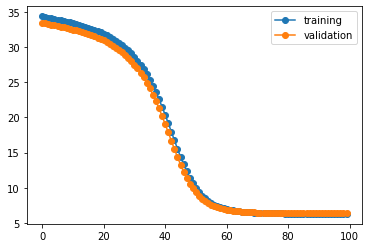

In [167]:
train_loss = mnet_regr.history[:, 'train_loss']
valid_loss = mnet_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [168]:
ympred_train = mnet_regr.predict(Xm)
ympred_train.shape

(1763, 12)

### Loop through each task and look at parity plot?

In [169]:
def check_mt_pred_results(y,ypred,title):
    '''
    Check individual task predictions within MT?
    '''
    for i in cond_dict:
        task=cond_dict[i]
        subtitle = f"{task} - {title}"
        print(f"task:{task}")
        yi = y[:,i]
        ypredi = ypred[:,i]

        pr = scipy.stats.pearsonr(np.array(yi).flatten(),ypredi.flatten())
        ytrue_pred_hist(yi,ypredi,subtitle)
        parity_plot(f"skorch cnn {task}", yi, ypredi,pr[0],rigid=True)

task:uMax


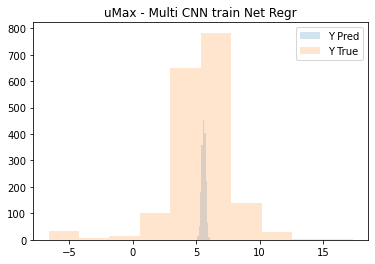

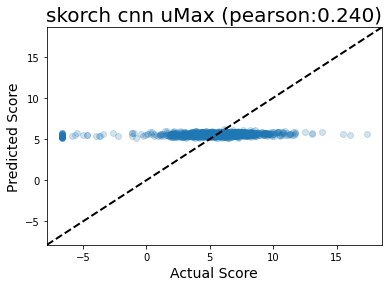

task:lowO2_fast_growth


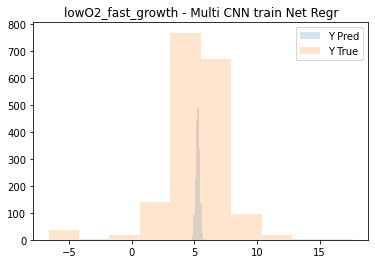

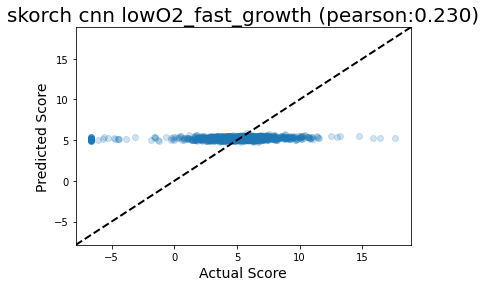

task:lowCH4


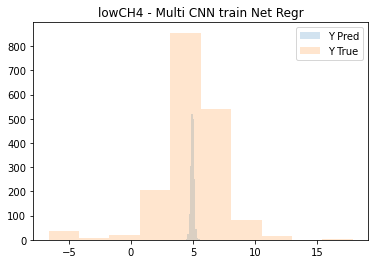

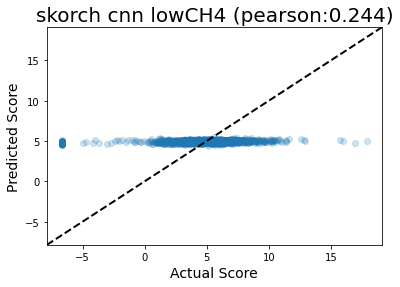

task:MeOH


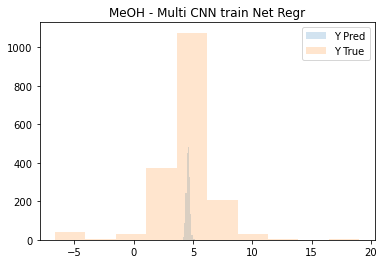

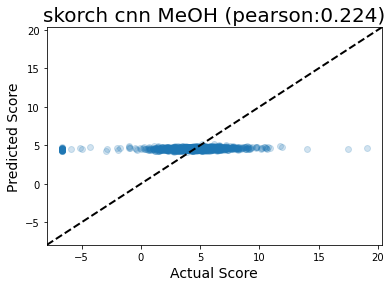

task:NoCu


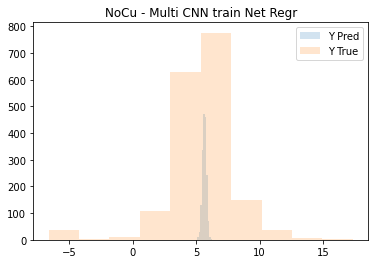

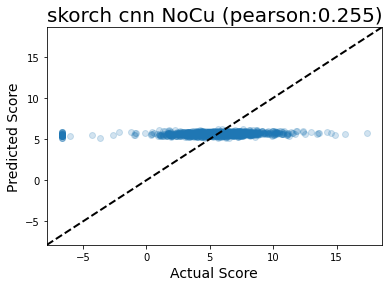

task:medCu


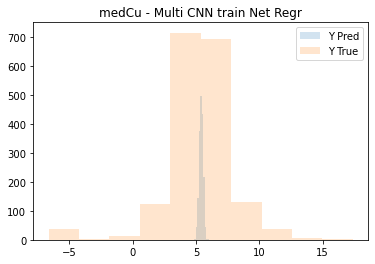

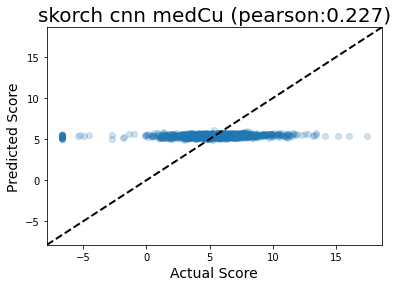

task:highCu


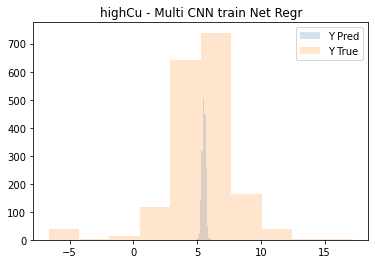

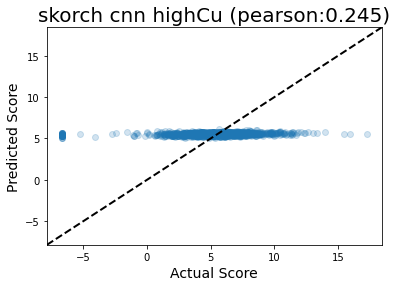

task:lowCu


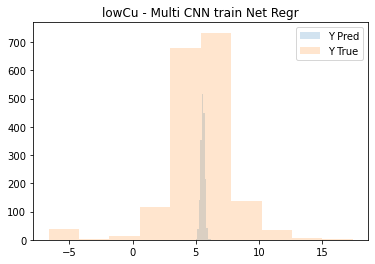

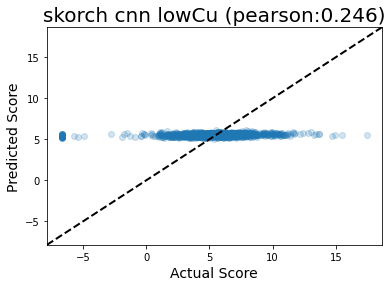

task:highO2_slow_growth


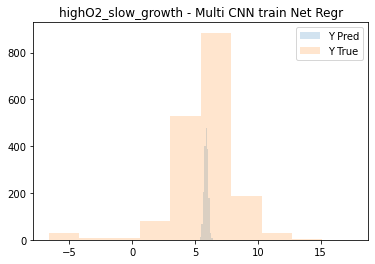

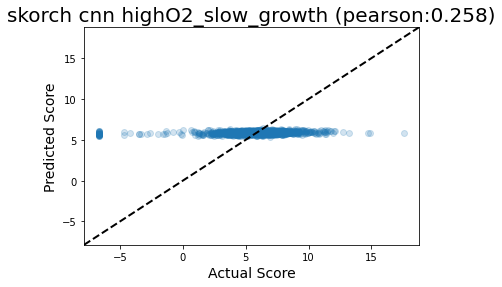

task:NO3_lowO2_slow_growth


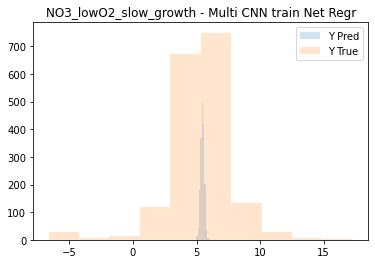

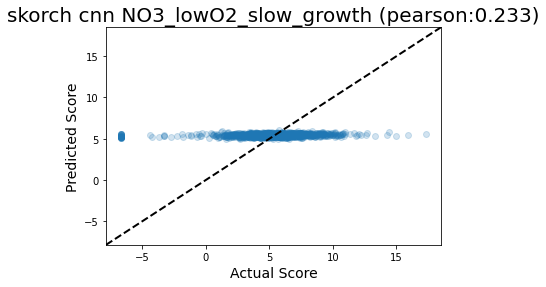

task:WithLanthanum


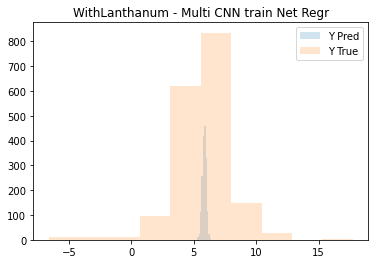

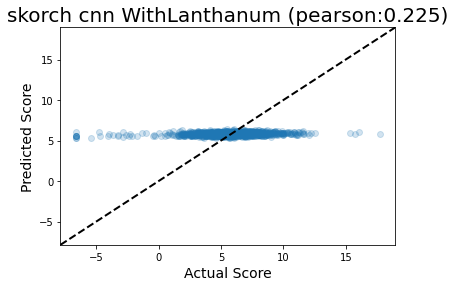

task:NoLanthanum


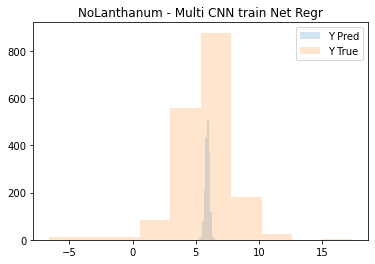

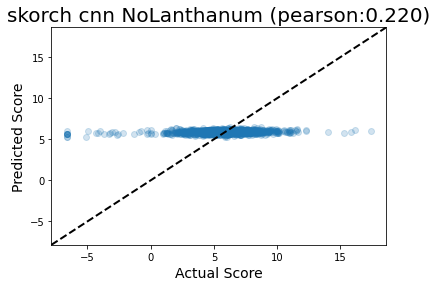

In [170]:
check_mt_pred_results(ym, ympred_train, "Multi CNN train Net Regr")

# skorch param search with MT

In [182]:
params = {
    'lr': [0.0005, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

mnet_search = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    module__n_tasks=ym.shape[1],
    max_epochs=500,
    #lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[
        EarlyStopping(patience=25),#,sink=print),
        #Checkpoint(dirname='testcheck_search',f_pickle='model.pkl'),
    ]
)

m_search = RandomizedSearchCV(
    mnet_search, 
    params, 
    n_iter=50, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=5,#cv, 
    random_state=1,
    verbose=2
)

In [183]:
m_search.fit(Xm, ym)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.6min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.1970       32.6235  0.0528
      2       33.0544       31.5314  0.0490
      3       31.9497       30.4520  0.0495


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 13.7min finished


      4       30.8419       29.3512  0.0494
      5       29.6996       28.2029  0.0487
      6       28.4988       26.9875  0.0487
      7       27.2222       25.6924  0.0484
      8       25.8596       24.3129  0.0484
      9       24.4099       22.8543  0.0485
     10       22.8826       21.3332  0.0484
     11       21.2989       19.7777  0.0483
     12       19.6917       18.2262  0.0484
     13       18.1024       16.7222  0.0489
     14       16.5757       15.3078  0.0496
     15       15.1518       14.0165  0.0487
     16       13.8606       12.8680  0.0489
     17       12.7173       11.8678  0.0491
     18       11.7237       11.0093  0.0490
     19       10.8710       10.2790  0.0490
     20       10.1448        9.6606  0.0489
     21        9.5290        9.1379  0.0485
     22        9.0080        8.6967  0.0482
     23        8.5679        8.3245  0.0491
     24        8.1966        8.0109  0.0484
     25        7.8837        7.7470  0.0487
     26        7.6204        7.5

    137        5.8551        6.1734  0.0491
    138        5.8506        6.1709  0.0494
    139        5.8461        6.1685  0.0486
    140        5.8416        6.1661  0.0483
    141        5.8371        6.1636  0.0481
    142        5.8326        6.1612  0.0485
    143        5.8280        6.1588  0.0486
    144        5.8235        6.1564  0.0485
    145        5.8190        6.1539  0.0484
    146        5.8144        6.1515  0.0487
    147        5.8099        6.1491  0.0484
    148        5.8053        6.1467  0.0487
    149        5.8008        6.1443  0.0488
    150        5.7962        6.1419  0.0482
    151        5.7917        6.1395  0.0483
    152        5.7871        6.1370  0.0488
    153        5.7825        6.1346  0.0483
    154        5.7780        6.1322  0.0484
    155        5.7734        6.1298  0.0486
    156        5.7688        6.1275  0.0492
    157        5.7643        6.1251  0.0491
    158        5.7597        6.1227  0.0494
    159        5.7551        6.1

    270        5.2282        5.8707  0.0499
    271        5.2233        5.8686  0.0489
    272        5.2184        5.8665  0.0487
    273        5.2135        5.8645  0.0489
    274        5.2085        5.8624  0.0493
    275        5.2036        5.8603  0.0489
    276        5.1987        5.8582  0.0496
    277        5.1937        5.8561  0.0491
    278        5.1888        5.8540  0.0487
    279        5.1839        5.8519  0.0487
    280        5.1789        5.8499  0.0486
    281        5.1740        5.8478  0.0488
    282        5.1690        5.8457  0.0492
    283        5.1641        5.8437  0.0494
    284        5.1591        5.8416  0.0488
    285        5.1541        5.8396  0.0488
    286        5.1492        5.8375  0.0491
    287        5.1442        5.8354  0.0498
    288        5.1392        5.8334  0.0490
    289        5.1343        5.8314  0.0486
    290        5.1293        5.8293  0.0487
    291        5.1243        5.8273  0.0492
    292        5.1193        5.8

    402        4.5581        5.6333  0.0485
    403        4.5530        5.6319  0.0492
    404        4.5479        5.6306  0.0487
    405        4.5428        5.6293  0.0487
    406        4.5376        5.6280  0.0484
    407        4.5325        5.6267  0.0483
    408        4.5274        5.6254  0.0482
    409        4.5223        5.6241  0.0486
    410        4.5172        5.6228  0.0485
    411        4.5121        5.6216  0.0483
    412        4.5070        5.6203  0.0484
    413        4.5019        5.6191  0.0496
    414        4.4968        5.6179  0.0493
    415        4.4917        5.6166  0.0496
    416        4.4866        5.6154  0.0499
    417        4.4815        5.6143  0.0492
    418        4.4764        5.6131  0.0500
    419        4.4713        5.6119  0.0492
    420        4.4662        5.6107  0.0491
    421        4.4611        5.6096  0.0485
    422        4.4560        5.6085  0.0489
    423        4.4510        5.6073  0.0486
    424        4.4459        5.6

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN_Multi'>,
  module__n_tasks=12,
  module__seq_len=300,
),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'lr': [0.0005, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                         

In [196]:
m_search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 16), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=36480, out_features=50, bias=True)
      (3): Linear(in_features=50, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=12, bias=True)
    )
  ),
)

In [197]:
m_search.best_params_

{'optimizer': torch.optim.sgd.SGD,
 'module__num_filters': 128,
 'module__num_fc_nodes1': 50,
 'module__kernel_size': 16,
 'lr': 0.0001}

In [198]:
mres_df = pd.DataFrame(m_search.cv_results_)
mres_df['opt_name'] = mres_df['param_optimizer'].apply(lambda x: x.__name__)
mres_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,6.586623,1.122004,0.009085,0.000640,<class 'torch.optim.adam.Adam'>,16,10,32,0.0005,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.669457,-5.882116,-7.196084,-6.464084,-8.169736,-6.676296,0.915426,27,Adam
1,20.144253,2.819665,0.009594,0.000896,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.875748,-5.066127,-7.017351,-5.376423,-7.871328,-6.241396,1.050897,12,Adam
2,4.015722,0.475191,0.010269,0.001209,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.022224,-6.355192,-7.179332,-5.782631,-8.043320,-6.676540,0.830825,28,Adam
3,4.182944,0.349918,0.009532,0.000714,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.656823,-5.512506,-7.087627,-5.592738,-7.781294,-6.326198,0.932223,21,Adam
4,24.957061,3.032176,0.009164,0.000743,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.149260,-4.947794,-7.144092,-5.256017,-7.714781,-6.242389,1.061940,13,SGD
5,2.246069,0.183996,0.010021,0.000287,<class 'torch.optim.adam.Adam'>,64,100,32,0.0005,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-8.533494,-9.834692,-9.232156,-10.035759,-11.245238,-9.776268,0.902127,45,Adam
6,13.894495,2.880055,0.009922,0.000500,<class 'torch.optim.rmsprop.RMSprop'>,64,100,16,0.00001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-5.735898,-5.146817,-7.071190,-5.841700,-7.779860,-6.315093,0.963500,20,RMSprop
7,23.044798,4.860280,0.009269,0.000761,<class 'torch.optim.adagrad.Adagrad'>,32,25,32,0.0005,{'optimizer': <class 'torch.optim.adagrad.Adag...,-6.025227,-5.039608,-7.122095,-5.240117,-7.632170,-6.211843,1.019716,9,Adagrad
8,7.911824,1.425919,0.011259,0.001355,<class 'torch.optim.sgd.SGD'>,128,25,4,0.0005,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-5.542635,-5.199784,-6.806096,-5.442496,-7.770071,-6.152216,0.982592,5,SGD
9,3.803069,0.268375,0.012523,0.002079,<class 'torch.optim.adamw.AdamW'>,128,100,4,0.0005,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-9.227502,-8.267450,-9.957591,-9.806216,-11.464620,-9.744676,1.044700,44,AdamW


In [199]:
sm_mres_df = mres_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [200]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [201]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

In [202]:
ymsearch_pred_train = m_search.best_estimator_.predict(Xm)

task:uMax


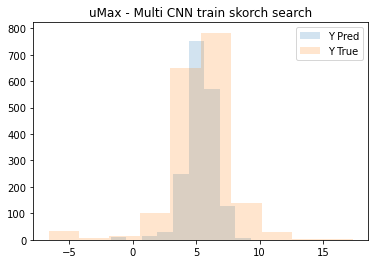

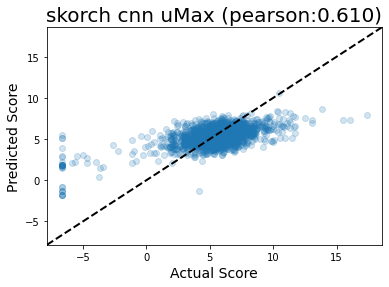

task:lowO2_fast_growth


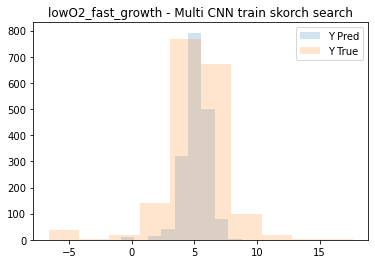

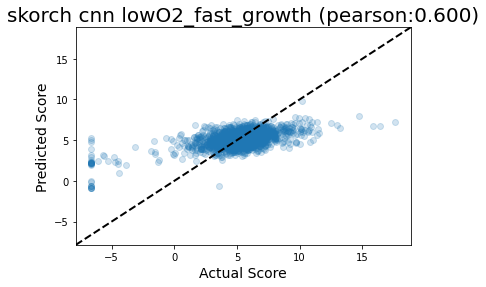

task:lowCH4


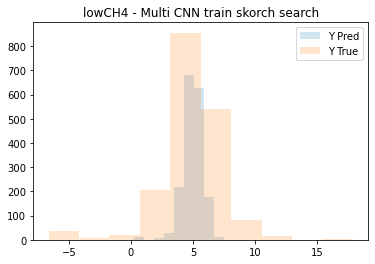

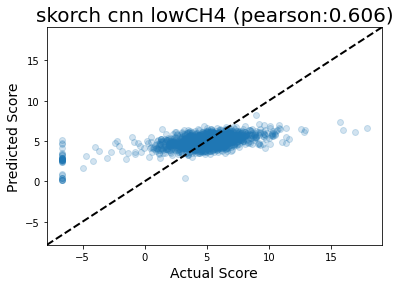

task:MeOH


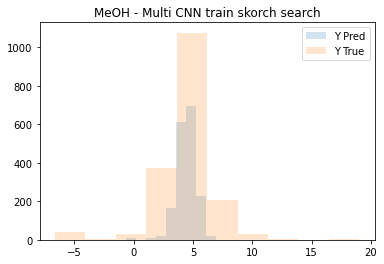

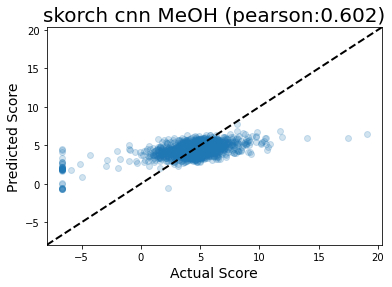

task:NoCu


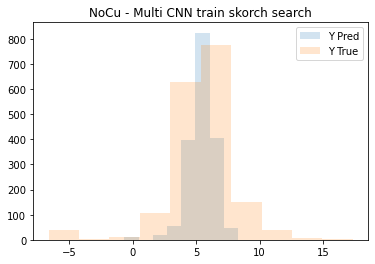

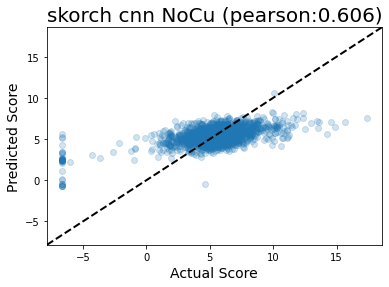

task:medCu


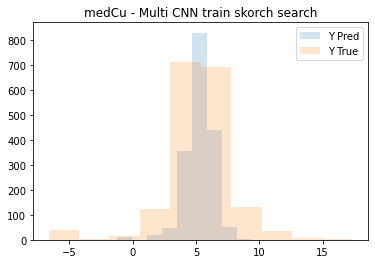

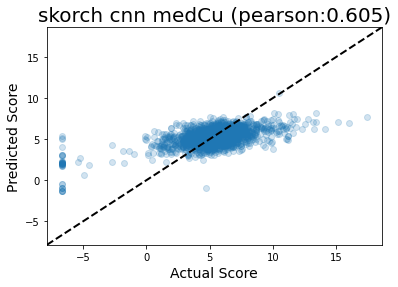

task:highCu


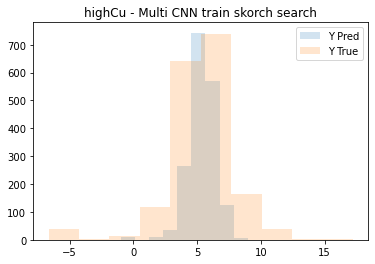

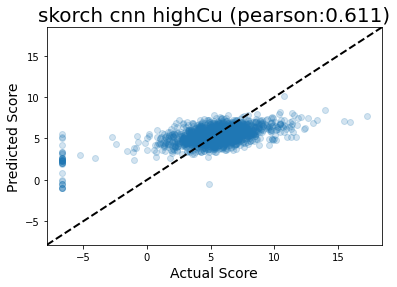

task:lowCu


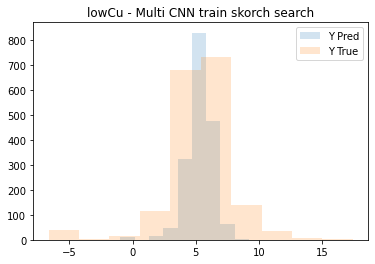

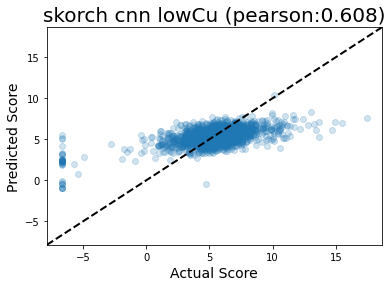

task:highO2_slow_growth


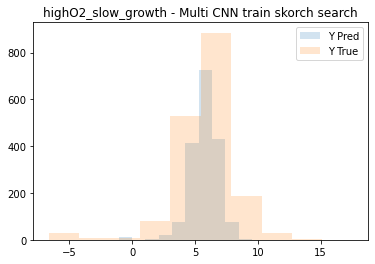

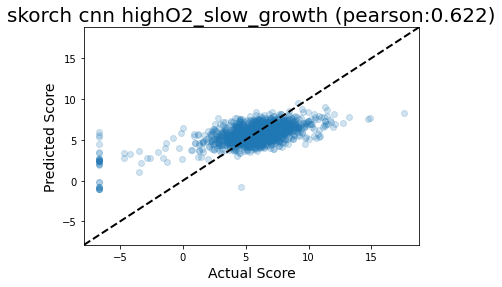

task:NO3_lowO2_slow_growth


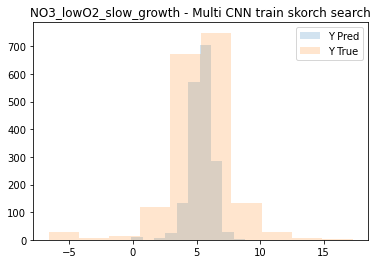

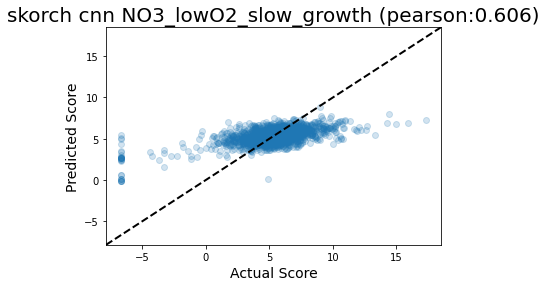

task:WithLanthanum


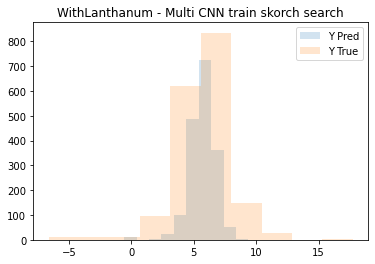

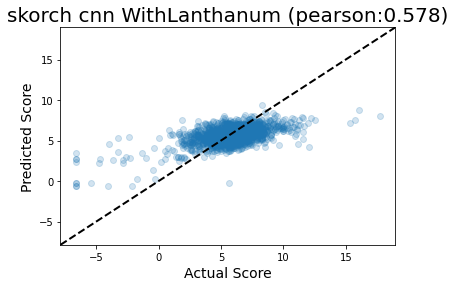

task:NoLanthanum


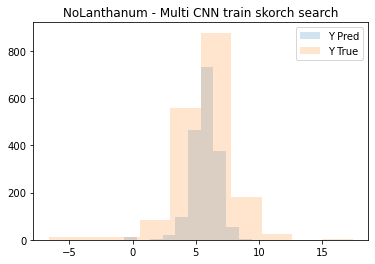

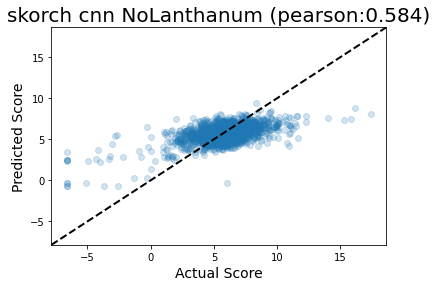

In [203]:
check_mt_pred_results(ym, ymsearch_pred_train,"Multi CNN train skorch search")

In [204]:
Xmtest,ymtest = make_multi_skorch_dfs(log_test_df, seq_col='upstream_region')
print("X m test:",Xmtest.shape)
print("y m test:",ymtest.shape)

X m test: torch.Size([441, 300, 4])
y m test: torch.Size([441, 12])


In [205]:
ymsearch_pred_test = m_search.best_estimator_.predict(Xmtest)

task:uMax


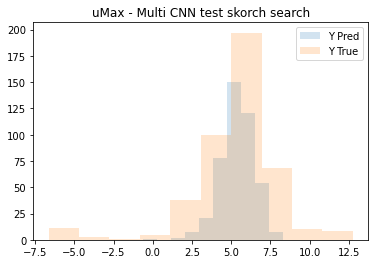

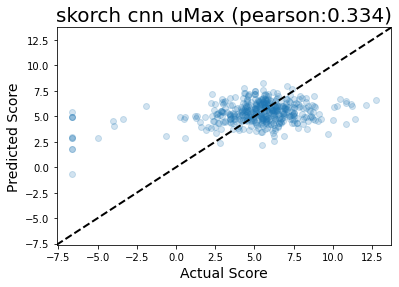

task:lowO2_fast_growth


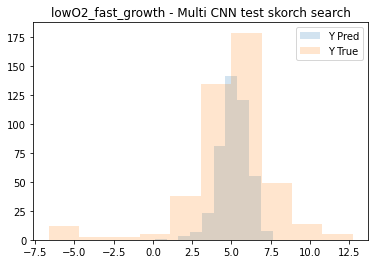

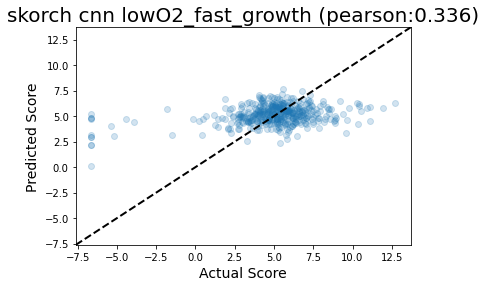

task:lowCH4


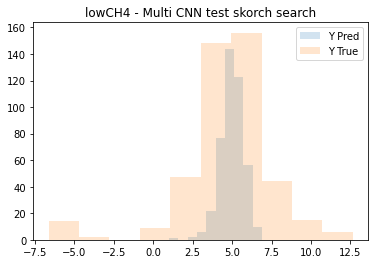

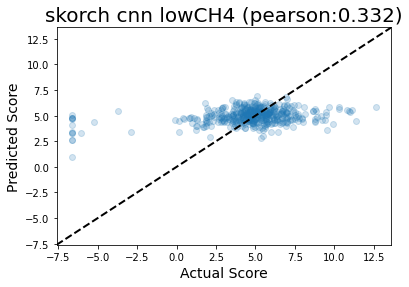

task:MeOH


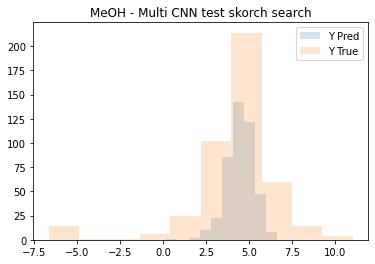

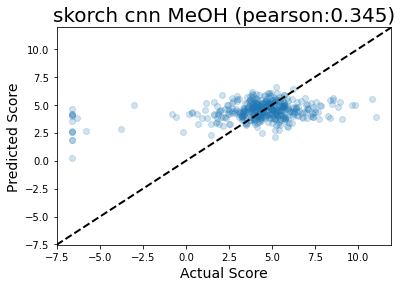

task:NoCu


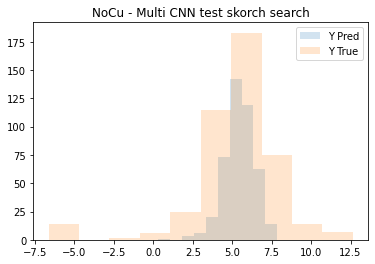

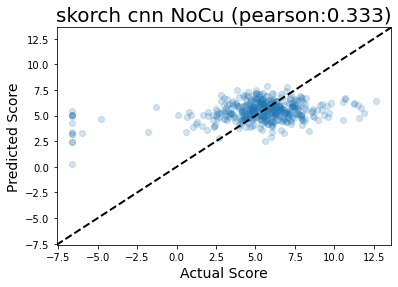

task:medCu


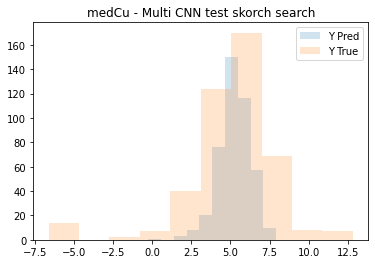

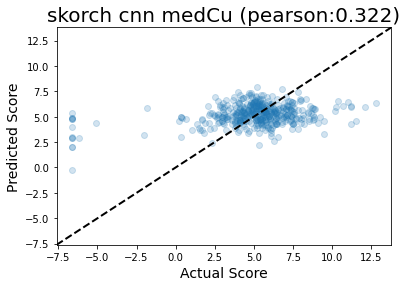

task:highCu


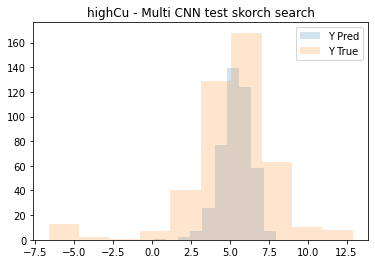

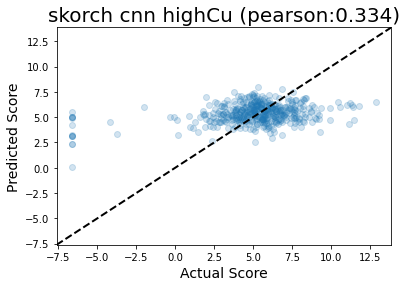

task:lowCu


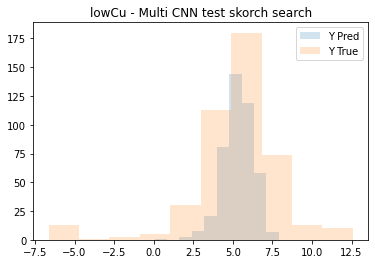

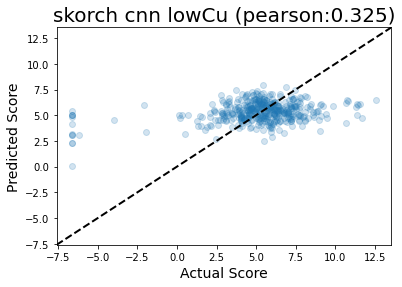

task:highO2_slow_growth


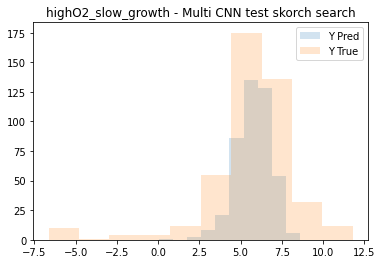

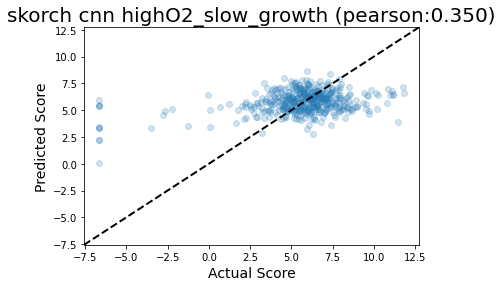

task:NO3_lowO2_slow_growth


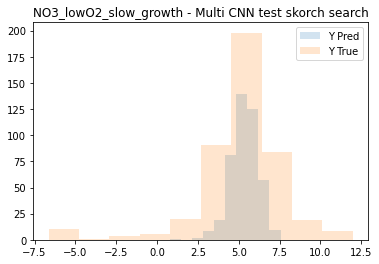

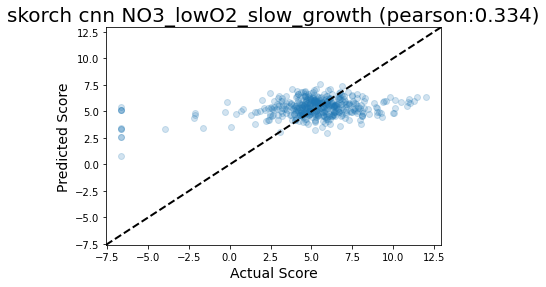

task:WithLanthanum


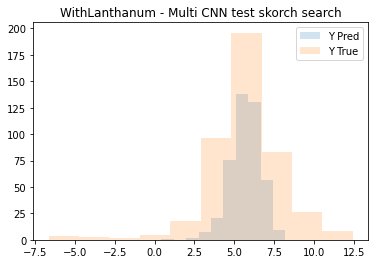

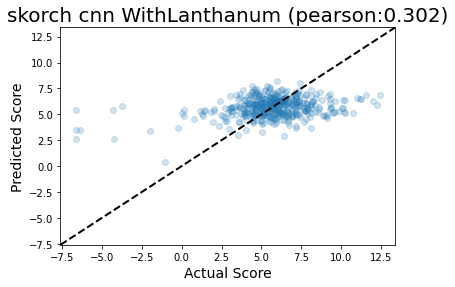

task:NoLanthanum


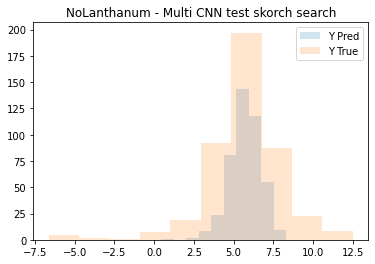

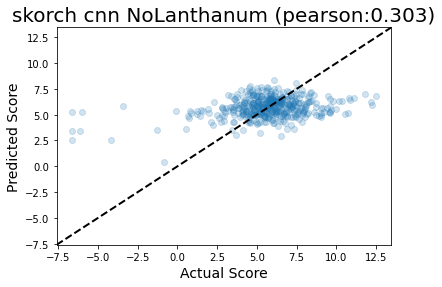

In [206]:
check_mt_pred_results(ymtest, ymsearch_pred_test,"Multi CNN test skorch search")

In [102]:
mres_df.to_csv("multi_skorch_search_res_df.tsv",sep='\t', index=False)

In [8]:
test = pd.read_csv('multi_skorch_search_res_df.tsv',sep='\t')

In [9]:
test

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,59.104487,0.685902,0.010845,0.001480,<class 'torch.optim.adam.Adam'>,16,10,32,0.00050,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.853952,-23.230394,-21.319815,-22.497879,-22.695402,-21.719489,1.562829,376,Adam
1,59.337368,2.253942,0.013646,0.002544,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.946605,-5.320988,-7.279854,-5.753273,-8.405795,-6.541303,1.138913,123,Adam
2,62.643943,0.526686,0.014259,0.001357,<class 'torch.optim.adam.Adam'>,128,25,8,0.00010,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-17.657255,-21.508598,-20.662313,-21.507624,-22.012827,-20.669724,1.567465,355,Adam
3,57.970003,2.599069,0.011775,0.001051,<class 'torch.optim.adam.Adam'>,32,100,4,0.00010,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.295582,-19.663145,-19.988087,-18.631847,-20.820629,-19.479858,0.917735,340,Adam
4,40.366428,4.052095,0.012646,0.002078,<class 'torch.optim.sgd.SGD'>,32,25,4,0.00010,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.104009,-4.963671,-7.213747,-5.209205,-7.599255,-6.217977,1.049131,47,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,54.819225,1.421057,0.013606,0.001281,<class 'torch.optim.rmsprop.RMSprop'>,128,10,8,0.00050,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-19.959888,-24.360632,-22.448183,-22.932302,-22.832281,-22.506657,1.429257,413,RMSprop
496,56.441145,0.595706,0.011243,0.000335,<class 'torch.optim.adam.Adam'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.131781,-4.998219,-6.853837,-5.415829,-7.572523,-6.194438,0.935417,31,Adam
497,43.649200,5.467568,0.015853,0.005174,<class 'torch.optim.sgd.SGD'>,32,10,8,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-7.034853,-9.071085,-13.716123,-13.504837,-8.366921,-10.338764,2.751057,248,SGD
498,77.238276,5.039324,0.017579,0.003002,<class 'torch.optim.adam.Adam'>,128,100,16,0.00050,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-21.778761,-26.515709,-24.488634,-25.060144,-24.044800,-24.377610,1.543660,460,Adam


In [10]:
sm_mres_df = test[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [11]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [12]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)